# Auxiliary Classifier Generative Adversarial Networks (AC-GAN)

- The Generative Adversarial Network (GAN) is an architecture for training a generative model, typically a deep convolutional neural networks for generating image. The architecture is comprised of a generator model that takes random points from a latent space as input which generates images and a discriminator for classifying images as either real (from the dataset) or fake (generated). Both models are then trained simultaneously in a zero-sum game.

- A conditional GAN (cGAN) is an extension of the GAN architecture that adds structure to the latent space. The training of the GAN model is changed so that the generator is provided both with a point in the latent space and a class label as input which attempts to generate an image for that class. The discriminator is provided with both an image and the class label and must classify whether the image is real or fake as before.

- The addition of the class as input makes the image generation process and image classification process conditional on the class label, hence the name. The effect is both a more stable training process and a resulting generator model that can be used to generate images of a given specific type, e.g. for a class label.

> __Auxiliary Classifier GAN (AC-GAN) is an extension of the Conditional GAN that changes the discriminator to predict the class label of a given image rather than receive it as input. This has the effect of stabilizing the training process and allowing the generation of large high-quality images whilst learning a representation in the latent space that is independent of the class label.__

- AC-GAN was introduced by Augustus Odena, et al. from Google Brain in the 2016 paper titled “[Conditional Image Synthesis with Auxiliary Classifier GANs.](https://arxiv.org/abs/1610.09585)”


#### Below image gives a summary of the differences between Conditional GAN, Semi-Supervised GAN, InfoGAN and Auxiliary Classifier GAN

<br>

![Summary of differences between Conditional GAN, Semi-Supervised GAN, InfoGAN, and Auxiliary Classifier GAN](Summary-of-the-Differences-Between-the-Conditional-GAN-Semi-Supervised-GAN-InfoGAN-a.png)

<br>

- The generator model in the AC-GAN is provided both with a point in the latent space and the class label as input, e.g. the image generation process is conditional. The main difference is in the discriminator model, which is only provided with the image as input, unlike the conditional GAN that is provided with the image and class label as input. The discriminator model must then predict whether the given image is real or fake as before and must also predict the class label of the image.

- The discriminator seeks to maximize the probability of correctly classifying real and fake images (LS) and correctly predicting the class label (LC) of a real or fake image (e.g. LS + LC). The generator seeks to minimize the ability of the discriminator to discriminate real and fake images whilst also maximizing the ability of the discriminator predicting the class label of real and fake images (e.g. LC – LS).

- The resulting generator learns a latent space representation that is independent of the class label, unlike the conditional GAN. The effect of changing the conditional GAN in this way is both a more stable training process and the ability of the model to generate higher quality images with a larger size than previously possible 128×128 pixels images.

<br>

You can visit this [link](https://github.com/tdikonda/deep_learning/blob/master/Generative_Adversarial_Networks_(GANs)/Conditional_GAN_on_Fashion_MNIST_Dataset_using_Keras/Conditional_GAN_on_Fashion_MNIST_Dataset_using_Keras.ipynb) to understand basics of Conditional GAN (cGAN)

### Lets begin with the implementation of Auxiliary Classifier GAN (AC-GAN)

## Check Google Colaboratory Jupyter Notebook Runtime Type and Load Necessary Libraries

In [0]:
# check if the jupyter notebook is running on a GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
# import necessary libraries
from math import sqrt
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Activation
from keras.layers.merge import Concatenate 
from keras.layers.core import Dense, Flatten, Dropout, Reshape
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.datasets import fashion_mnist
from keras.utils.vis_utils import plot_model
from IPython.display import Image
import glob
import imageio
import time

Using TensorFlow backend.


## Explore Fashion MNIST Clothing Photograph Dataset

- It is a dataset comprised of 70,000 small square 28×28 pixel grayscale images of items of 10 types of clothing such as shoes, t-shirts, dresses and more.

- Keras provides access to the Fashion-MNIST dataset via the fashion_mnist.load_dataset( ) function. It returns two tuples, one with the input and output elements for the standard training dataset and another with the input and output elements for the standard test dataset.

In [0]:
# load images
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


In [0]:
# check data shape
print(f'X Train shape {X_train.shape}, Y Train shape {y_train.shape}')
print(f'X Test shape {X_test.shape}, Y Test shape {y_test.shape}')
print(f'Unique labels for Images {np.unique(y_train)}')

X Train shape (60000, 28, 28), Y Train shape (60000,)
X Test shape (10000, 28, 28), Y Test shape (10000,)
Unique labels for Images [0 1 2 3 4 5 6 7 8 9]


> We can see that there are 60K examples in the training set and 10K in the test set and that each image is a square of 28 by 28 pixels. We have 10 unique class labels from 0 to 9 for our dataset.

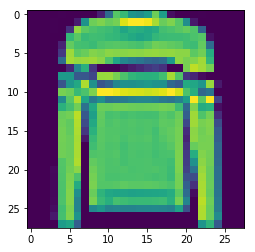

In [0]:
# check one of the train images
plt.imshow(X_train[5])

> The images are grayscale with a black background (0 pixel value) and the items of clothing are in white (pixel values near 255). This means if the images were plotted, they would be mostly black with a white item of clothing in the middle.

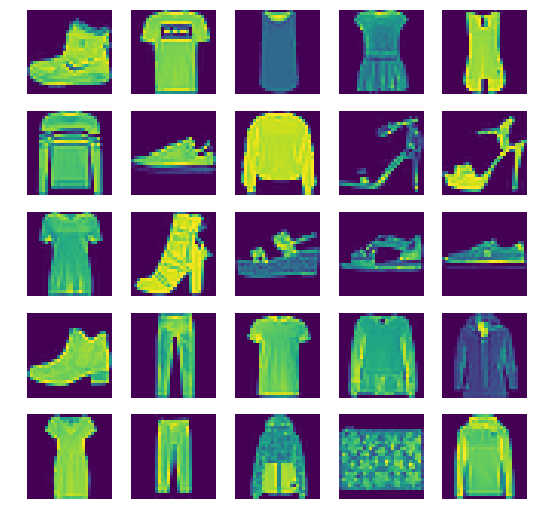

In [0]:
# checkout first 25 images
fig = plt.figure(figsize=(9,9))
    
# plot images
for i in range(25):
    # define subplot
    plt.subplot(5, 5, 1 + i)
    # plot raw pixel data
    plt.imshow(X_train[i])
    # turn off axis
    plt.axis('off')

## Build Generator Model

- The generator model must take a random point from the latent space as input and the class label, then output a generated grayscale image with the shape 28x28x1.

> __Input__ :- Random point from the latent space and the class label.

> __Output__ :- Generated image.

- The AC-GAN paper describes the AC-GAN generator model taking a vector input that is a concatenation of the point in latent space (100 dimensions) and the one hot encoded class label (10 dimensions) that is 110 dimensions.

- An alternative approach that has proven effective and is now generally recommended is to interpret the class label as an additional channel or feature map early in the generator model. This can be achieved by using a learned embedding with an arbitrary number of dimensions (e.g. 50), the output of which can be interpreted by a fully connected layer with a linear activation resulting in one additional 7×7 feature map.


```
    # initialize Gaussian Weight
    init = RandomNormal(mean=0.0, stddev=0.02)
    
    # input label
    input_label = Input(shape=(1,))
    
    # embedding for categorical input
    li = Embedding(n_classes, 50)(input_label)
    
    # linear multiplication
    li = Dense(7 * 7, kernel_initializer=init)(li)
    
    # reshape to add additional channel
    li = Reshape((7, 7, 1))(li)
```


- The point in latent space can be interpreted by a fully connected layer with sufficient activations to create multiple 7×7 feature maps, in this case 384 and provide the basis for a low-resolution version of our output image. The 7×7 single feature map interpretation of the class label can then be channel-wise concatenated resulting in 385 feature maps.


```
    # image generator input
    input_image = Input(shape=(latent_dim,))
    
    # base 7x7 image
    gen = Dense(384 * 7 * 7, kernel_initializer=init)(input_image)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)
    
    # merge image generator and input label
    merge = Concatenate()([gen, li])
```

- These feature maps can then go through the process of two transpose convolutional layers to upsample the 7×7 feature maps first to 14×14 pixels and then finally to 28×28 features, quadrupling the area of the feature maps with each upscaling step.

- The output of the generator is a single feature map or grayscale image with the shape 28×28 and pixel values in the range [-1, 1] given the choice of a tanh activation function. We use ReLU activation for the upscaling layers instead of LeakyReLU given the suggestion the AC-GAN paper.


```
    # upsample from 7x7 to 14x14
    gen = Conv2DTranspose(filters=192, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization(momentum=0.8)(gen)
    gen = Activation('relu')(gen)
    
    # upsample from 14x14 to 28x28
    gen = Conv2DTranspose(1, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    output_layer = Activation('tanh')(gen)
```

- We can tie all of this together and into build_generator( ) function defined below that will create and return the generator model for AC-GAN.




In [0]:
# define generator model
def build_generator(latent_dim=200, n_classes=10):
    # initialize Gaussian Weight
    init = RandomNormal(mean=0.0, stddev=0.02)
    # input label
    input_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(input_label)
    # linear multiplication
    li = Dense(7 * 7, kernel_initializer=init)(li)
    # reshape to add additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    input_image = Input(shape=(latent_dim,))
    
    # base 7x7 image
    gen = Dense(384 * 7 * 7, kernel_initializer=init)(input_image)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)
    
    # merge image generator and input label
    merge = Concatenate()([gen, li])
    
    # upsample from 7x7 to 14x14
    gen = Conv2DTranspose(filters=192, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization(momentum=0.8)(gen)
    gen = Activation('relu')(gen)
    
    # upsample from 14x14 to 28x28
    gen = Conv2DTranspose(1, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    output_layer = Activation('tanh')(gen)
    
    # define model
    model = Model([input_image, input_label], output_layer)
    return model

# create the generator
g_model = build_generator()

# generator model summary
g_model.summary()







Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 18816)        3782016     input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_1[0][0]                    
______________________________________________________________________________________

> We can confirm that the latent dimension input is 200 dimensions and that the class label input is a single integer. We can also confirm that the output of the embedding class label is correctly concatenated as an additional channel resulting in 385, 7×7 feature maps prior to the transpose convolutional layers. The summary also confirms the expected output shape of a single grayscale 28×28 image.

### Plot Generator Model

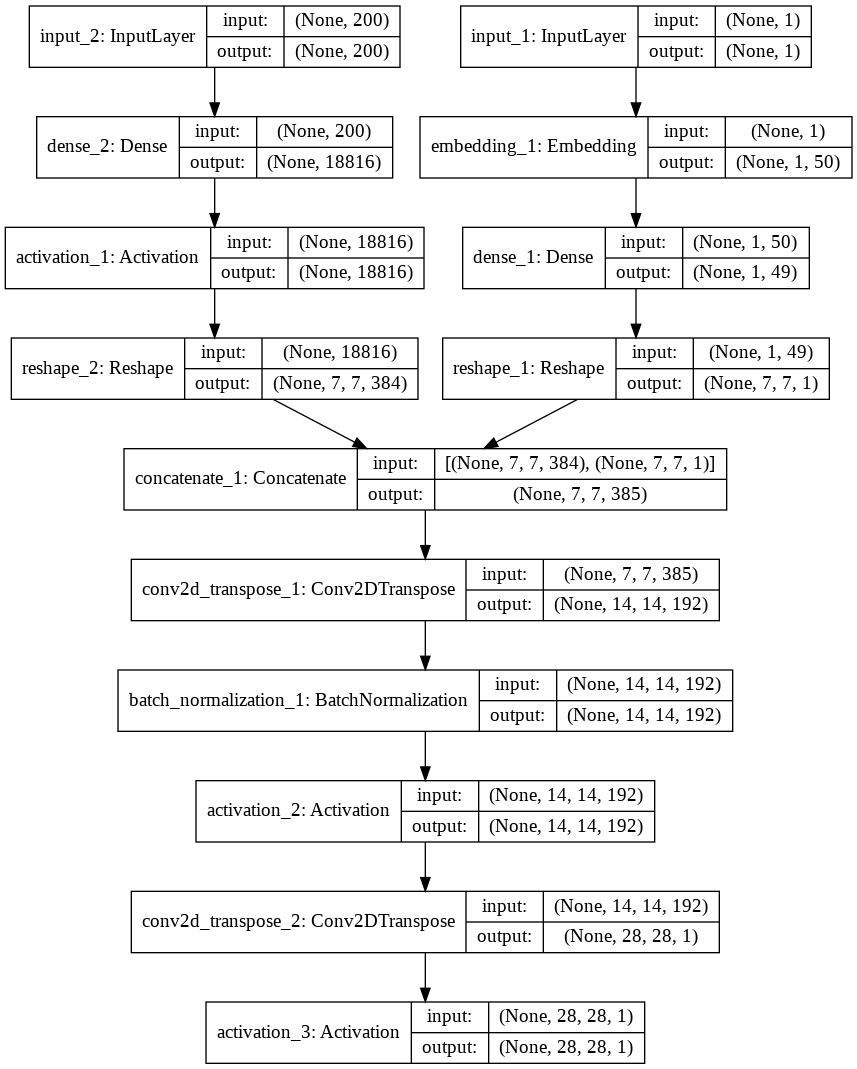

In [0]:
# plot generator model
plot_model(g_model, to_file='acgan_generator_model_plot.png', show_shapes=True, show_layer_names=True)
Image(filename='acgan_generator_model_plot.png', retina=True)

> The plot confirms the two inputs to the network and the correct concatenation of the inputs.

## Build Discriminator Model

- The input images will have the shape 28x28x1 and there are 10 classes for the items of clothing in the Fashion MNIST dataset. The shape of the input images and the number of classes are parameterized and set with defaults allowing them to be easily changed for your own future projects.

- The model can be defined as per the DCGAN architecture. That is using Gaussian weight initialization, a 2×2 stride for downsampling instead of pooling layers, a kernel size that is a factor of the stride size, BatchNormalization, LeakyReLU and Dropout.

> __Input__ :- Image

> __Output__ :- Probability that the provided image is real, probability of the image belonging to each known class

- The discriminator model takes real and fake images as input and outputs following two probabilities

    - The first output is a single probability via the sigmoid activation function that indicates the “realness” of the input image and is optimized using binary cross entropy like a normal GAN discriminator model.
    
    > output_layer_1 = Dense(1, activation='sigmoid')(dis)

    - The second output is a probability of the image belonging to each class like any given multi-class classification neural network model via the softmax activation function which is optimized using categorical cross entropy.
    
    > output_layer_2 = Dense(n_classes, activation='softmax')(dis)
    
    - We can then construct the image with a single input and two outputs.
    
    > model = Model(input_image, [output_layer_1, output_layer_2])
    
- The model must be trained with two loss functions, binary cross entropy for the first output layer and categorical cross-entropy loss for the second output layer. Rather than comparing a one hot encoding of the class labels to the second output layer as we might do normally, we can compare the integer class labels directly.

- We can achieve this automatically using the sparse categorical cross-entropy loss function. This will have the identical effect of the categorical cross-entropy but avoids the step of having to manually one hot encode the target labels. When compiling the model, we can inform Keras to use the two different loss functions for the two output layers by specifying a list of function names as strings

    > loss = ['binary_crossentropy', 'sparse_categorical_crossentropy']
    
- The model is then fit using the Adam version of stochastic gradient descent with a small learning rate and modest momentum as recommended for DCGANs.
    









In [0]:
# define discriminator model
def build_discriminator(input_shape=(28,28,1), n_classes=10):
    # initialize Gaussian Weight
    init = RandomNormal(mean=0.0, stddev=0.02)
    # input image
    input_image = Input(shape=input_shape)

    # input 28x28 real and fake images and downsample from 28x28 to 14x14
    dis = Conv2D(filters=64, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(input_image)
    dis = LeakyReLU(alpha=0.2)(dis)
    dis = Dropout(0.5)(dis)

    # 2D Convolution Layer
    dis = Conv2D(filters=128, kernel_size=(4,4), padding='same', kernel_initializer=init)(dis)
    dis = BatchNormalization(momentum=0.8)(dis)
    dis = LeakyReLU(alpha=0.2)(dis)
    dis = Dropout(0.5)(dis)
    
    # downsample from 14x14 to 7x7
    dis = Conv2D(filters=256, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(dis)
    dis = BatchNormalization(momentum=0.8)(dis)
    dis = LeakyReLU(alpha=0.2)(dis)
    dis = Dropout(0.5)(dis)
    
    # 2D Convolution Layer
    dis = Conv2D(filters=512, kernel_size=(4,4), padding='same', kernel_initializer=init)(dis)
    dis = BatchNormalization(momentum=0.8)(dis)
    dis = LeakyReLU(alpha=0.2)(dis)
    dis = Dropout(0.5)(dis)
    
    # flatten feature maps
    dis = Flatten()(dis)
    
    # real/fake output
    output_layer_1 = Dense(1, activation='sigmoid')(dis)
    
    # class label output
    output_layer_2 = Dense(n_classes, activation='softmax')(dis)
    
    # define model
    model = Model(input_image, [output_layer_1, output_layer_2])
    
    # compile model
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=Adam(lr=0.0002, beta_1=0.5))
    return model

# create the discriminator
d_model = build_discriminator()

# discriminator model summary
d_model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   1088        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 14, 14, 64)   0           conv2d_1[0][0]                   
________________________________________________________________________________

### Plot Discriminator Model

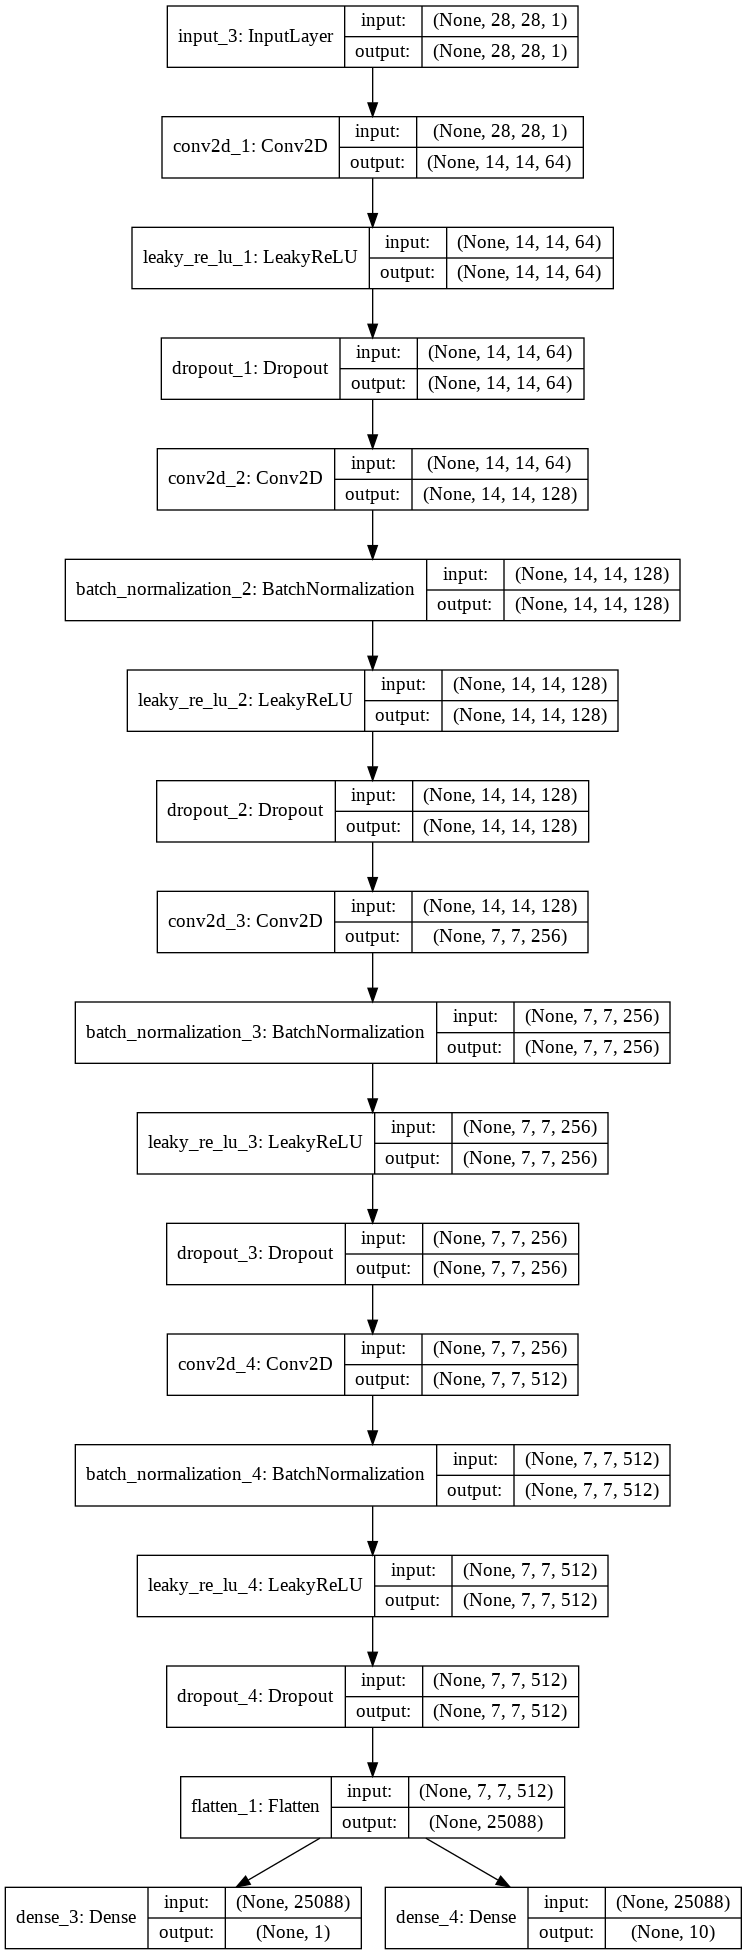

In [0]:
# plot discriminator model
plot_model(d_model, to_file='acgan_discriminator_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='acgan_discriminator_model_plot.png')

> The Discriminator Model plot confirms the expected shape of input images and the two output layers, one for image classification and other for class label classification.

## Build GAN Model

- The generator model is not updated directly, instead it is updated via the discriminator model. This can be achieved by creating a composite model that stacks the generator model on top of the discriminator model.

- The input to this composite model is the input to the generator model, namely a random point from the latent space and a class label. The generator model is connected directly to the discriminator model, which takes the generated image directly as input. Finally, the discriminator model predicts both the realness of the input image and the class label. As such, the composite model is optimized using two loss functions, one for each output of the discriminator model.

- The discriminator model is updated in a standalone manner using real and fake examples. Therefore, we do not want to update the discriminator model when updating (training) the composite model; we only want to use this composite model to update the weights of the generator model.

- This can be achieved by setting the layers of the discriminator as not trainable prior to compiling the composite model. This only has an effect on the layer weights when viewed or used by the composite model and prevents them from being updated when the composite model is updated.

- The build_gan( ) function below implements this taking the already defined generator and discriminator models as input and defining a new composite model that can be used to update the generator model only.

In [0]:
# combine the generator and discriminator model for updating the generator
def build_gan(g_model, d_model):
    # do not train weights in the discriminator
    d_model.trainable = False
    # connect images from the generator as inputs to discriminator
    gan_output = d_model(g_model.output)
    # define GAN model taking noise and label and output real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile the model
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=Adam(lr=0.0002, beta_1=0.5))
    return model

# create composite GAN model
gan_model = build_gan(g_model, d_model)

# composite GAN model summary
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 18816)        3782016     input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_1[0][0]                    
____________________________________________________________________________________________

### Plot GAN Model

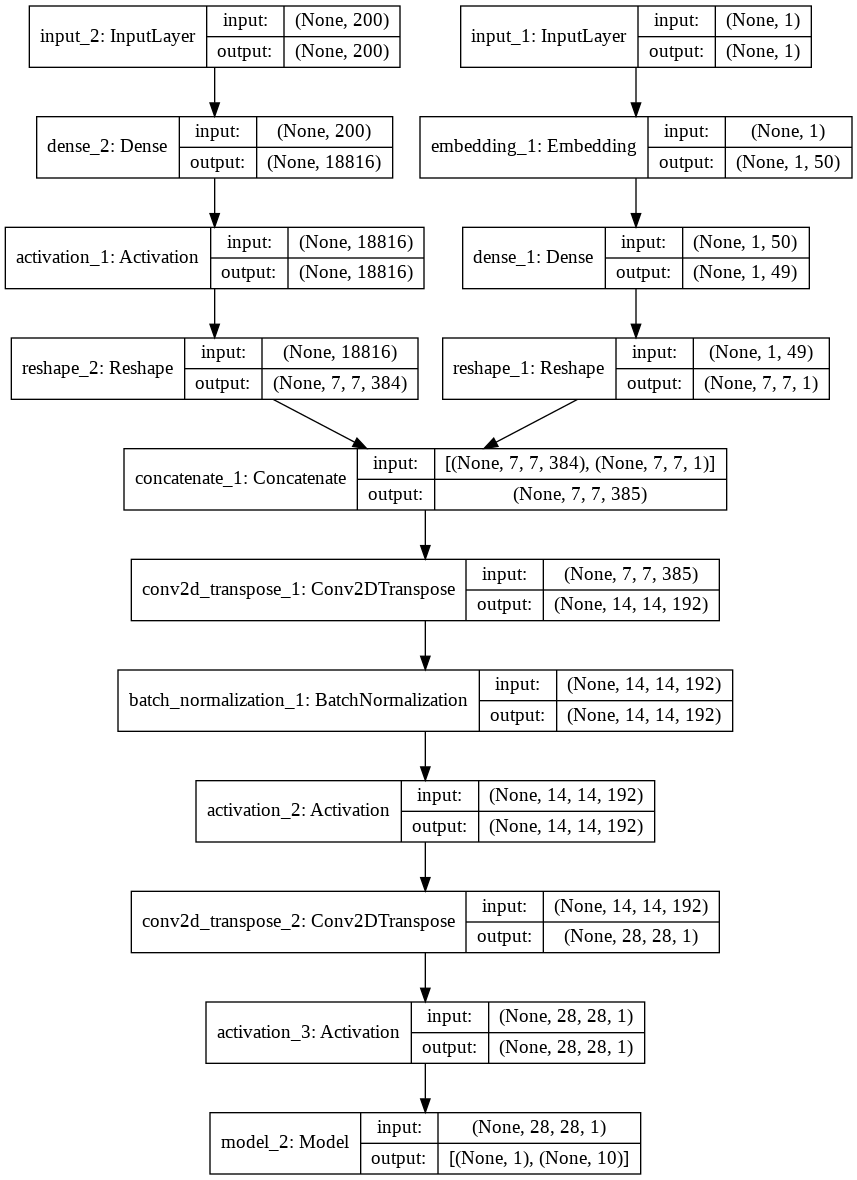

In [0]:
# plot composite GAN model
plot_model(gan_model, to_file='acgan_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='acgan_plot.png')

## Load Real Image Dataset

- The Fashion MNIST input data needs to be loaded and prepared. We only require the images in the training dataset. The images are black and white, therefore we must add an additional channel dimension to transform them to be three dimensional, as expected by the convolutional layers of our models.

- The pixel values must also be scaled from the range of unsigned integers in [0,255] to the normalized range of [-1,1] to match the output of the generator model.

In [0]:
# load and prepare Fashion MNIST training images
def load_real_samples():
    # load fashion_mnist dataset
    (X_train, y_train), (_, _) = fashion_mnist.load_data()
    # expand to 3D i.e add channel dimension
    X_train = expand_dims(X_train, axis=-1)
    # convert from unsigned ints to floats
    X_train = X_train.astype('float32')
    # scale from [0,255] to [0,1]
    #dataset = train_images / 255.0
    # scale from [0,255] to [-1,1]
    X_train = (X_train - 127.5) / 127.5
    return [X_train, y_train]

## Get Random Real Image Samples

- We will require batches of real images from the dataset to update the GAN model. A simple way to achieve this is to select a random sample of images from the dataset each time.

- The get_real_samples( ) function below implements this, taking the prepared dataset, selecting and returning a random sample of Fashion MNIST images and their corresponding class label for the discriminator, specifically class=1 indicating that they are real images.

In [0]:
# get random real image samples
def get_real_samples(dataset, n_samples):
    # split dataset into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # retrieve random images and its corresponding labels
    X_real, labels_real = images[ix], labels[ix]
    # generate 'real' class labels (1)
    y_real = ones((n_samples, 1))
    return [X_real, labels_real], y_real

## Generate Latent Points

- We need inputs for the generator model which are random points from the latent space, specifically Gaussian distributed random variables.

- The generate_latent_points( ) function implements this, taking the size of the latent space as an argument, number of points required and returning them as a batch of input samples for the generator model. The function also returns randomly selected integers in [0,9] inclusively for the 10 class labels in the Fashion-MNIST dataset.

In [0]:
# generate points in latent space as input to the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate input labels
    input_labels = randint(0, n_classes, n_samples)
    return [z_input, input_labels]

## Generate Fake Image Samples

- The generate_fake_samples( ) function returns fake generated images and their corresponding class label. The function also generates labels specifically class=0 to indicate they are fake or generated.

In [0]:
# use the generator to generate n fake examples with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_fake = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X_fake = g_model.predict([z_input, labels_fake])
    # create 'fake' class labels (0)
    y_fake = zeros((n_samples, 1))
    return [X_fake, labels_fake], y_fake

## Generate Latent Points Specific to Class Label

- The generate_points_and_labels( ) function outputs latent points and class labels which will be the input for the generator model.

In [0]:
# generate latent points and class specific labels
def generate_points_and_labels(latent_dim, n_examples, n_class):
	# generate points in the latent space
	l_points = randn(latent_dim * n_examples)
	# reshape into a batch of inputs for the network
	l_points = l_points.reshape(n_examples, latent_dim)
	# generate labels
	l_labels = asarray([n_class for _ in range(n_examples)])
	return [l_points, l_labels]

## Plot Generated Images

- The plot_images( ) function below plots fake/generated clothing item specific to a class label at regular epoch intervals.

In [0]:
# plot generated images
def plot_images(X_fake, n_examples, i):
    # set figure size
    fig = plt.figure(figsize=(10,10))
    
    # plot images
    for k in range(n_examples):
        # define subplot
        plt.subplot(sqrt(n_examples), sqrt(n_examples), 1 + k)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(X_fake[k, :, :, 0])
    # save plot to file
    plt.savefig('image_at_epoch_{:04d}.png'.format(i+1))
    # show the plot
    plt.show()

## Summarize Performance

- There are no reliable ways to determine when to stop training a GAN; instead images can be subjectively inspected in order to choose a final model.

- Therefore, we can periodically generate a sample of images using the generator model and save the generator model to file for later use. The summarize_performance( ) function below implements this, generating 25 images, plotting them, saving the plot and the generator model to a file with a filename that includes the training “epoch” number.

- Discriminator's Loss on Real/Fake Images, Discriminator's Loss on Class Labels and Generator's Loss on Real/Fake Images and Labels is also reported every 5 epochs.

In [0]:
# report discriminator and generator loss, generate and plot fake images and save generator model
def summarize_performance(i, latent_dim, n_examples, n_class, g_model, d_loss_real, d_loss_real_label, d_loss_fake, d_loss_fake_label, g_loss_image, g_loss_label):
    # print epoch
    print(f'Epoch --> {i+1}')
    # get Discriminator's Loss on Images
    print(f"Discriminator's Loss on real: {d_loss_real:.4f} and fake: {d_loss_fake:.4f} Images")
    # get Discriminator's Loss on Labels
    print(f"Discriminator's Loss on real: {d_loss_real_label:.4f} and fake: {d_loss_fake_label:.4f} Labels")
    # get Generator's Loss on Images and Labels
    print(f"Generator's Loss on Images: {g_loss_image:.4f}; Generator's Loss on Labels: {g_loss_label:.4f}")
    # generate latent points and labels
    l_points, l_labels = generate_points_and_labels(latent_dim, n_examples, n_class)
    # generate fake images
    X_fake = g_model.predict([l_points, l_labels])
    # scale from [-1,1] to [1,0]
    X_fake = (X_fake + 1) / 2.0
    # plot generated images
    plot_images(X_fake, n_examples, i)
    # save the generator model to a file
    filename = 'acgan_generator_model_%03d.h5' % (i+1)
    g_model.save(filename)

## Plot Discriminator and Generator Loss

In [0]:
# plot Generator and Discriminator Loss
def plot_history(d_loss_real_hist, d_loss_real_label_hist, d_loss_fake_hist, d_loss_fake_label_hist, g_loss_image_hist, g_loss_label_hist):
    plt.figure(figsize=(14,8))
    
    # plot Discriminator's Loss on real/fake images
    plt.subplot(3, 1, 1)
    plt.plot(d_loss_real_hist, label="Discriminator's Loss on Real Images")
    plt.plot(d_loss_fake_hist, label="Discriminator's Loss on Fake Images")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Discriminator's Loss on Real and Fake Images")
    plt.legend()

    # plot Discriminator's Loss on real/fake labels
    plt.subplot(3, 1, 2)
    plt.plot(d_loss_real_label_hist, label="Discriminator's Loss on Real Labels")
    plt.plot(d_loss_fake_label_hist, label="Discriminator's Loss on Fake Labels")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Discriminator's Loss on Real and Fake Labels")
    plt.legend()
    
    # plot Generator's Loss on Images and Labels
    plt.subplot(3, 1, 3)
    plt.plot(g_loss_image_hist, label="Generator's Loss on Real/Fake Images")
    plt.plot(g_loss_label_hist, label="Generator's Loss on Labels")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Generator's Loss on Images and Labels")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## Train GAN

- We are now ready to train the GAN models. The model is fit for 75 training epochs, which is arbitrary as the model begins generating plausible items of clothing after perhaps 20 epochs. A batch size of 256 samples is used and each training epoch involves 60,000/256 or about 234 batches of real and fake samples and updates to the model. The summarize_performance( ) function is called every 5 epochs or every 1172 (234 * 5) training steps.

- For a given training step, first the discriminator model is updated for a half batch of real samples, then a half batch of fake samples, together forming one batch of weight updates. The generator is then updated via the combined GAN model. Importantly, the class label is set to 1 or real for the fake samples. This has the effect of updating the generator toward getting better at generating real samples on the next batch.

- Note, the discriminator and composite model return three loss values from the call to the train_on_batch( ) function. The first value is the sum of the loss values and can be ignored, whereas the second value is the loss for the real/fake output layer and the third value is the loss for the clothing label classification.

- The train_gan( ) function below implements this, taking the defined models, dataset, size of the latent dimension, class label and number of epcohs as arguments and parameterizing batch size with default argument. The generator model is saved at the end of training.

In [0]:
# train the generator and discriminator
def train_gan(g_model, d_model, gan_model, dataset, latent_dim, n_class, n_examples, n_epochs, n_batch=256):
    # calculate number of batches per training epoch
    batch_per_epoch = int(dataset[0].shape[0] / n_batch)
    # calculate number of training iterations
    #iterations = batch_per_epoch * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # list for storing loss at each iteration
    d_loss_real_hist, d_loss_fake_hist, d_loss_real_label_hist, d_loss_fake_label_hist, g_loss_image_hist, g_loss_label_hist  = list( ), list( ), list( ), list( ), list( ), list( )
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over training set
        for j in range(batch_per_epoch):
            # get random 'real' samples
            [X_real, labels_real], y_real = get_real_samples(dataset, half_batch)
            # update discriminator model weights
            _, d_loss_real, d_loss_real_label = d_model.train_on_batch(X_real, [y_real, labels_real])
            # generate 'fake' samples
            [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            _, d_loss_fake, d_loss_fake_label = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
            # prepare points in latent space as input to the generator
            [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via discriminator's error
            _, g_loss_image, g_loss_label = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
            # record history for discriminator and generator loss
            d_loss_real_hist.append(d_loss_real)
            d_loss_real_label_hist.append(d_loss_real_label)
            d_loss_fake_hist.append(d_loss_fake)
            d_loss_fake_label_hist.append(d_loss_fake_label)
            g_loss_image_hist.append(g_loss_image)
            g_loss_label_hist.append(g_loss_label)
        # summarize performance at specific epoch
        if (i+1) % 5 == 0:
            summarize_performance(i, latent_dim, n_examples, n_class, g_model, d_loss_real, d_loss_real_label, d_loss_fake, d_loss_fake_label, g_loss_image, g_loss_label)

    # save generator model
    #g_model.save('cdcgan_model.h5')
    # plot Generator and Discriminator Loss
    plot_history(d_loss_real_hist, d_loss_real_label_hist, d_loss_fake_hist, d_loss_fake_label_hist, g_loss_image_hist, g_loss_label_hist)

## Run GAN

- The AC-GAN technically does not conditionally generate images based on the class label, at least not in the same way as the conditional GAN. Nevertheless, if used in this way, the generated images mostly match the class label.

- The example below generates 25 examples of class 7 (sneaker).

- We can now define the size of the latent space, number of epochs and train them on the loaded fashion MNIST dataset.

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch --> 5
Discriminator's Loss on real: 0.1576 and fake: 0.3117 Images
Discriminator's Loss on real: 0.4559 and fake: 0.3086 Labels
Generator's Loss on Images: 4.0741; Generator's Loss on Labels: 0.5181


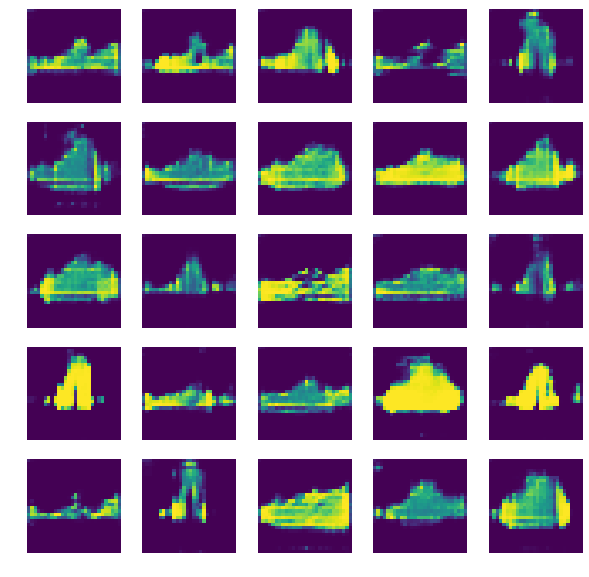

Epoch --> 10
Discriminator's Loss on real: 0.2021 and fake: 0.2913 Images
Discriminator's Loss on real: 0.6099 and fake: 0.3186 Labels
Generator's Loss on Images: 3.7238; Generator's Loss on Labels: 0.4109


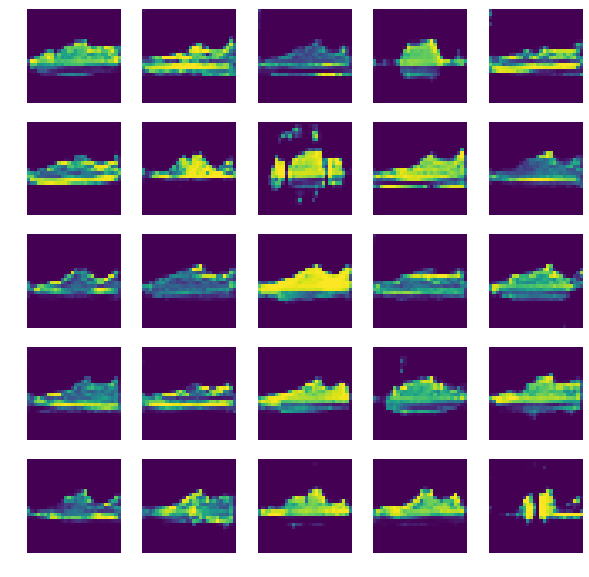

Epoch --> 15
Discriminator's Loss on real: 0.3431 and fake: 0.4153 Images
Discriminator's Loss on real: 0.4554 and fake: 0.3222 Labels
Generator's Loss on Images: 3.2196; Generator's Loss on Labels: 0.3545


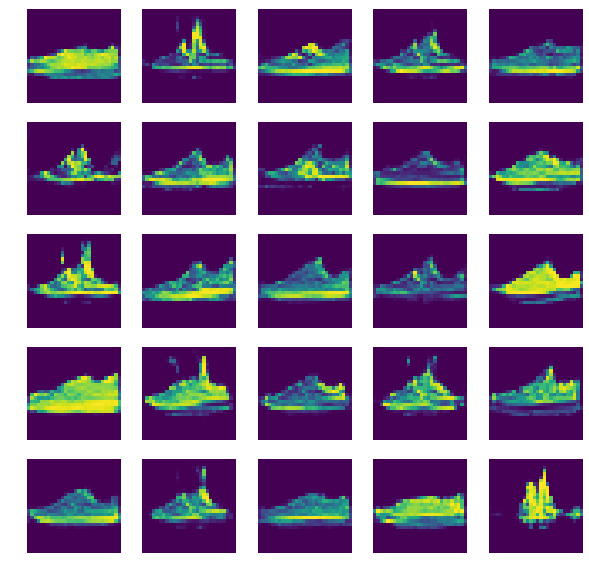

Epoch --> 20
Discriminator's Loss on real: 0.2910 and fake: 0.4125 Images
Discriminator's Loss on real: 0.8267 and fake: 0.1613 Labels
Generator's Loss on Images: 4.2004; Generator's Loss on Labels: 0.4335


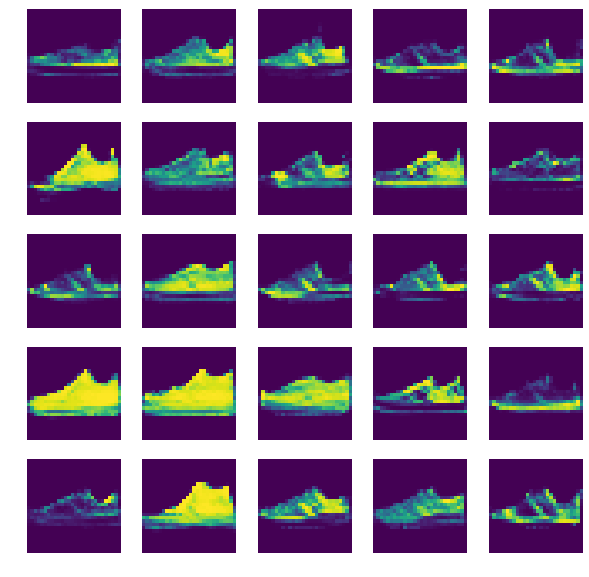

Epoch --> 25
Discriminator's Loss on real: 0.2759 and fake: 0.4523 Images
Discriminator's Loss on real: 0.6553 and fake: 0.3936 Labels
Generator's Loss on Images: 3.6327; Generator's Loss on Labels: 0.3109


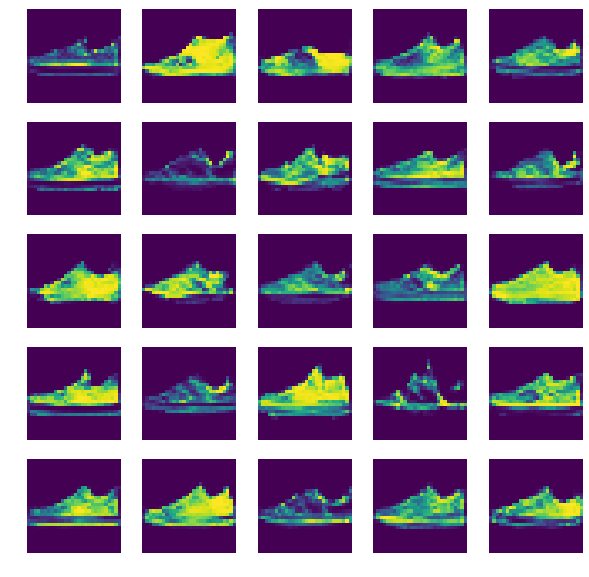

Epoch --> 30
Discriminator's Loss on real: 0.4313 and fake: 0.2464 Images
Discriminator's Loss on real: 0.6595 and fake: 0.3056 Labels
Generator's Loss on Images: 2.5790; Generator's Loss on Labels: 0.2754


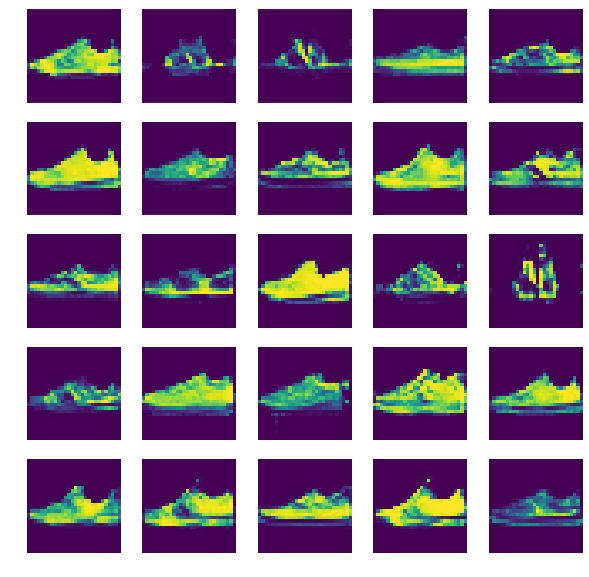

Epoch --> 35
Discriminator's Loss on real: 0.4837 and fake: 0.3900 Images
Discriminator's Loss on real: 0.5455 and fake: 0.2879 Labels
Generator's Loss on Images: 3.0043; Generator's Loss on Labels: 0.2773


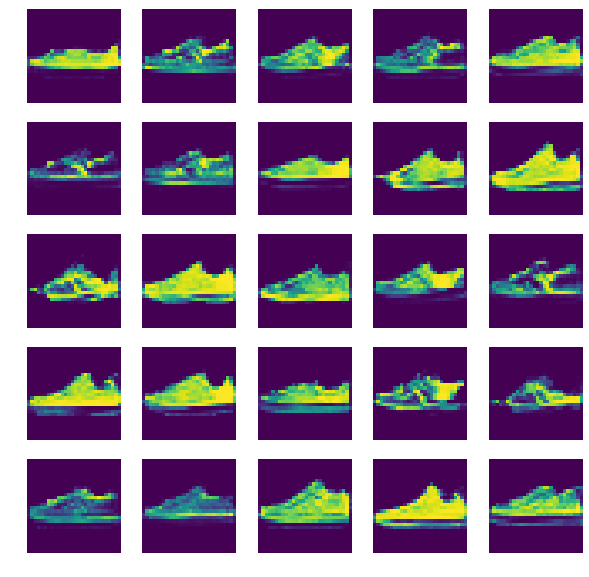

Epoch --> 40
Discriminator's Loss on real: 0.2361 and fake: 0.4165 Images
Discriminator's Loss on real: 0.6393 and fake: 0.3405 Labels
Generator's Loss on Images: 3.6724; Generator's Loss on Labels: 0.2868


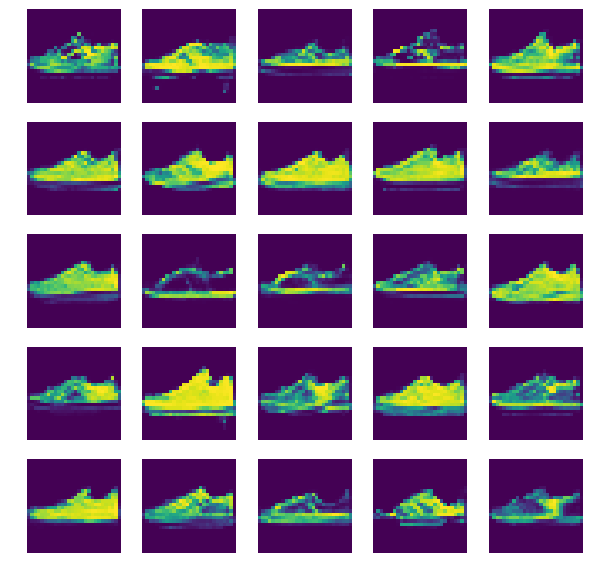

Epoch --> 45
Discriminator's Loss on real: 0.7077 and fake: 0.5918 Images
Discriminator's Loss on real: 0.4030 and fake: 0.4479 Labels
Generator's Loss on Images: 2.6280; Generator's Loss on Labels: 0.3225


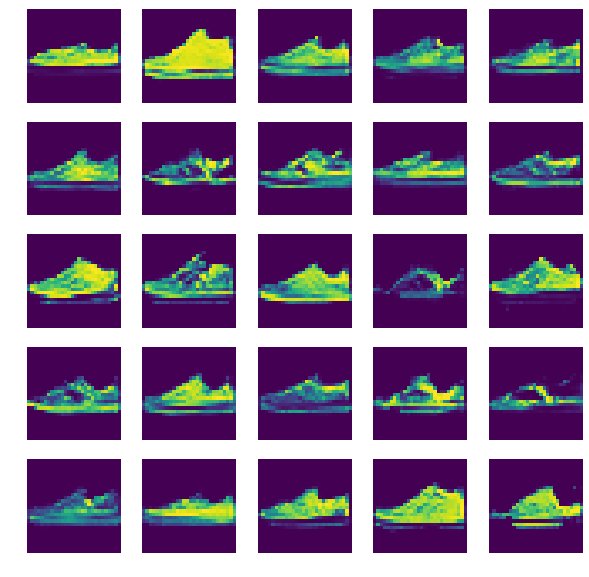

Epoch --> 50
Discriminator's Loss on real: 0.5868 and fake: 0.7234 Images
Discriminator's Loss on real: 0.4193 and fake: 0.4111 Labels
Generator's Loss on Images: 2.7544; Generator's Loss on Labels: 0.2681


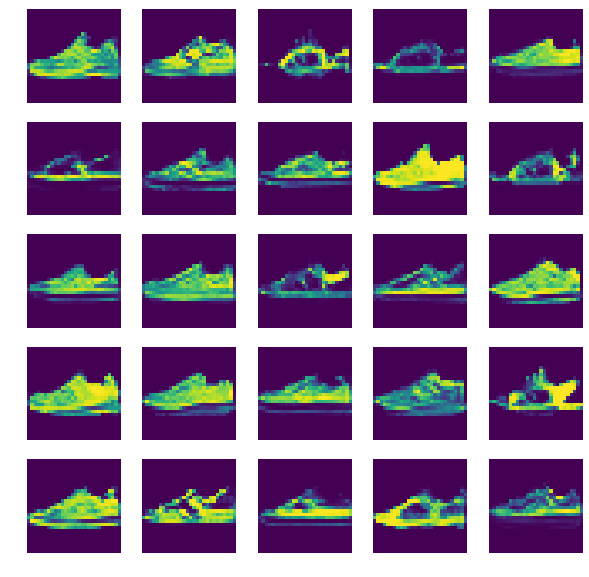

Epoch --> 55
Discriminator's Loss on real: 0.5077 and fake: 0.3800 Images
Discriminator's Loss on real: 0.4980 and fake: 0.4118 Labels
Generator's Loss on Images: 2.3041; Generator's Loss on Labels: 0.3538


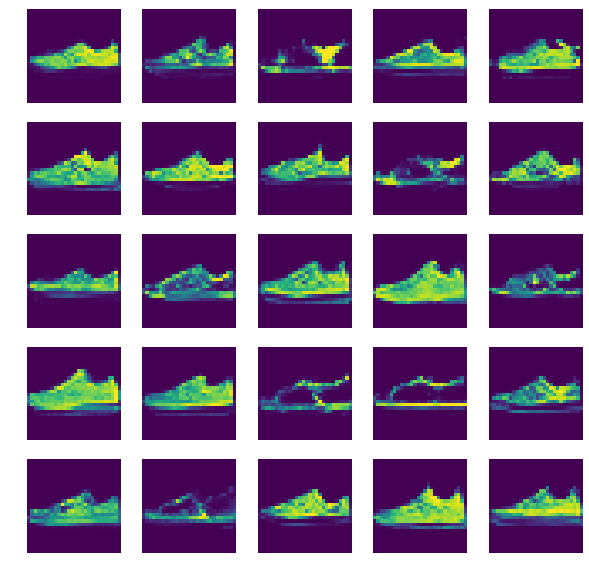

Epoch --> 60
Discriminator's Loss on real: 0.3731 and fake: 0.3517 Images
Discriminator's Loss on real: 0.6187 and fake: 0.2979 Labels
Generator's Loss on Images: 2.7780; Generator's Loss on Labels: 0.3102


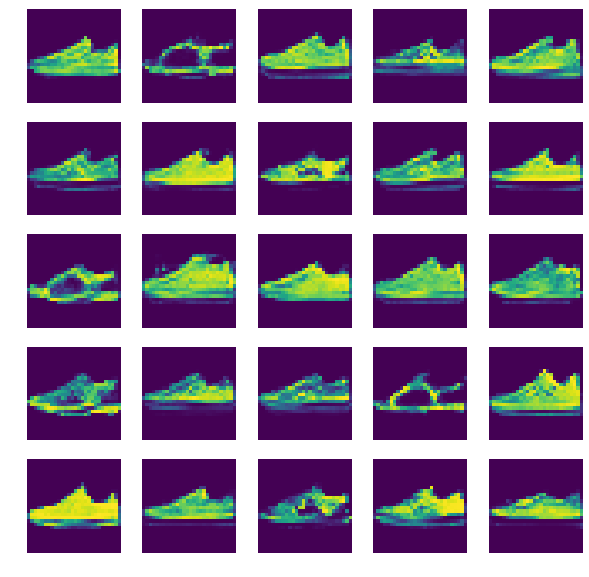

Epoch --> 65
Discriminator's Loss on real: 0.1861 and fake: 0.2331 Images
Discriminator's Loss on real: 0.7001 and fake: 0.2740 Labels
Generator's Loss on Images: 3.5302; Generator's Loss on Labels: 0.2098


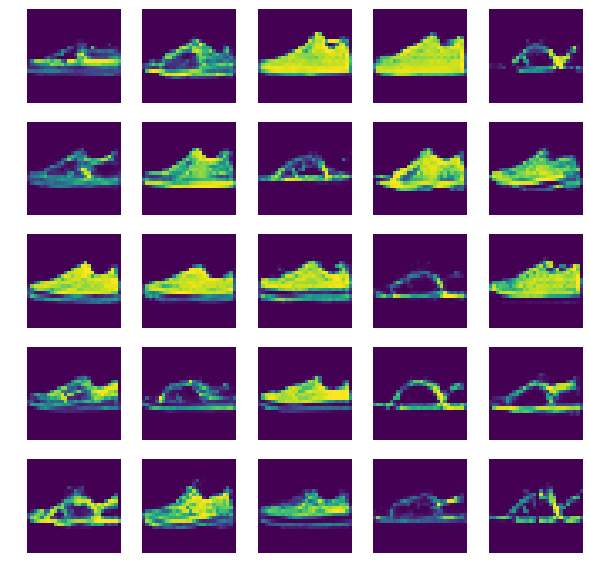

Epoch --> 70
Discriminator's Loss on real: 0.5646 and fake: 0.6757 Images
Discriminator's Loss on real: 0.4943 and fake: 0.3002 Labels
Generator's Loss on Images: 2.9732; Generator's Loss on Labels: 0.3502


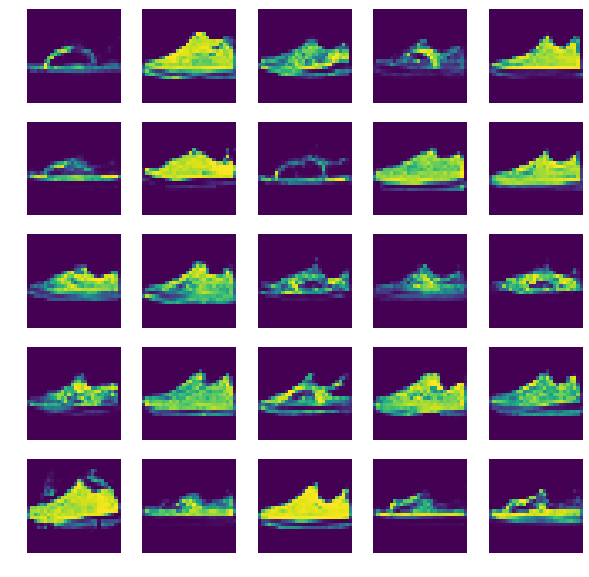

Epoch --> 75
Discriminator's Loss on real: 1.1885 and fake: 0.6059 Images
Discriminator's Loss on real: 0.4384 and fake: 0.2728 Labels
Generator's Loss on Images: 2.2149; Generator's Loss on Labels: 0.3878


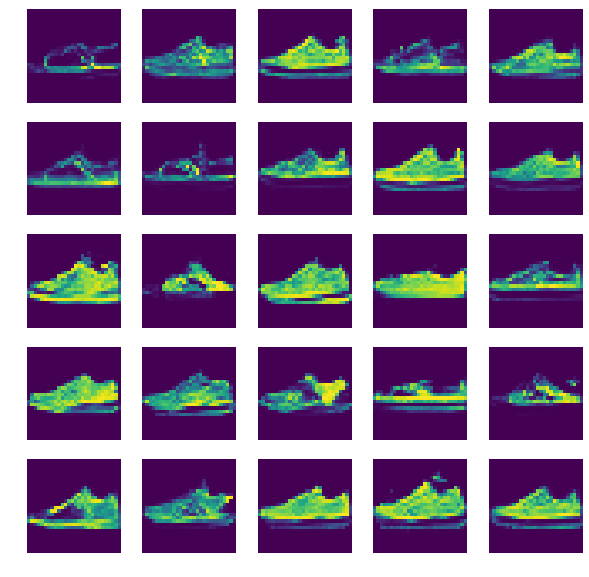

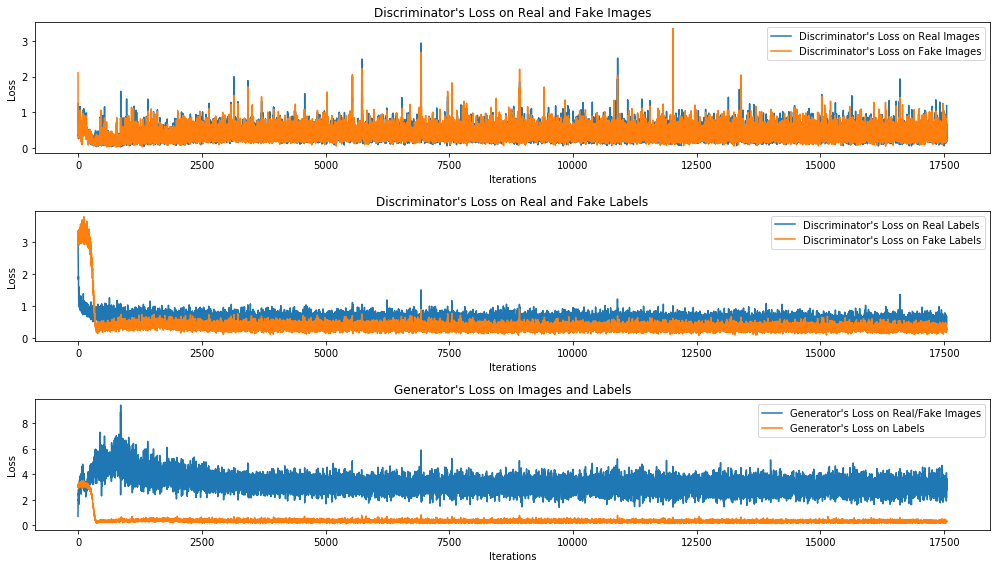

CPU times: user 1h 7min 49s, sys: 32min 14s, total: 1h 40min 3s
Wall time: 2h 18min 32s


In [0]:
# calculate execution time
%%time
# size of latent space
latent_dim = 200
# class label (in this example sneaker)
n_class = 7
# number of examples
n_examples = 25
# number of epochs
n_epochs = 75
# load image dataset
dataset = load_real_samples()
# create composite GAN
gan_model = build_gan(g_model, d_model)
# train GAN
train_gan(g_model, d_model, gan_model, dataset, latent_dim, n_class, n_examples, n_epochs)

## Create and Display GIF

In [0]:
# create a gif from specified intervals
gif_file = 'acgan-mnist.gif'

with imageio.get_writer(gif_file, mode='I') as writer:
    filenames = glob.glob('image_at_epoch*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [0]:
# display the gif
import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=gif_file)

![acgan-mnist](acgan-mnist.gif)

## Download GIF

In [0]:
# dowmload the gif
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(gif_file)

## References
[Conditional Image Synthesis With Auxiliary Classifier GANs](https://arxiv.org/abs/1610.09585)

[ACGAN on Fashion MNIST Dataset using Keras](https://machinelearningmastery.com/how-to-develop-an-auxiliary-classifier-gan-ac-gan-from-scratch-with-keras/)